# Домашнее задание 1

In [1]:
from Bio import SeqIO
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from math import log

## 1. GC состав

Релизуем функцию ```GC(file)```, которая вычисляет GC состав для передаваемого в нее файла. 

In [69]:
def GC(file):
    # список, в котором будет храниться количество ридов для каждого процента GC
    GC_list = [i for i in range(101)]   
    
    # для каждого рида считаем процентный состав и добавляем +1 в список GC_list[получившийся процент]
    for index, record in enumerate(SeqIO.parse(file, 'fastq')):
        sequence = record.seq
        num_nucl = Counter(sequence)
        GC_freq = round((num_nucl['G'] + num_nucl['C']) * 100 / len(sequence), 2)
        GC_list[int(GC_freq)] += 1
        
    return GC_list

Посчитаем для каждого файла GC состав.

In [56]:
GC_list1 = GC('100x.1.fastq')
GC_list2 = GC('100x.2.fastq')

Построим графики распределения GC состава для обоих файлов.

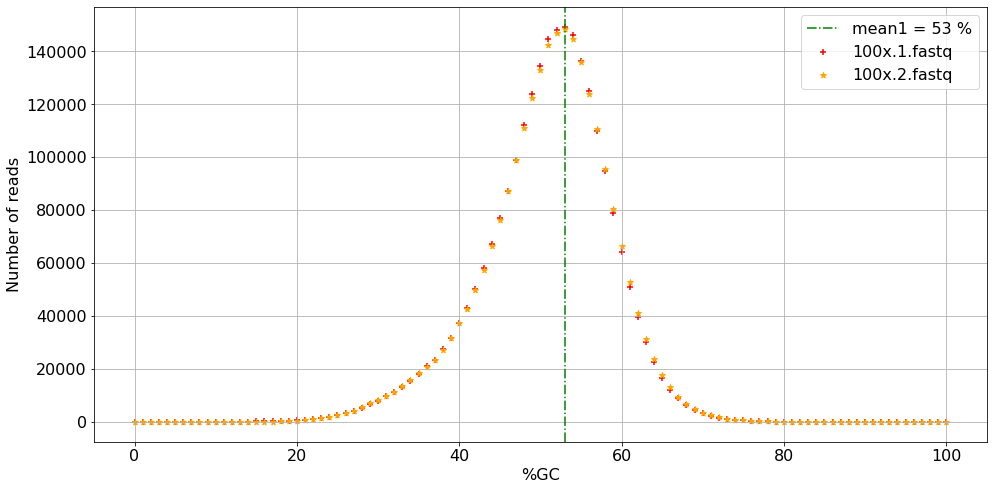

In [67]:
x, y, z = np.array([i for i in range(101)]), np.array(GC_list1), np.array(GC_list2)

fig, ax = plt.subplots(figsize=(16, 8))
plt.rcParams.update({'font.size': 16})

ax.scatter(x, y, marker = '+', color = 'red', label = '100x.1.fastq')
ax.scatter(x, z, marker = '*', color = 'orange', label = '100x.2.fastq')
ax.axvline(x = x[np.argmax(y)], color='green', linestyle='-.', label = f'mean1 = {x[np.argmax(y)]} %')

plt.xlabel('%GC')
plt.ylabel('Number of reads')
leg = ax.legend()
plt.grid()

## 2. Распределение качества

Согласно https://en.wikipedia.org/wiki/Phred_quality_score вероятность ошибки рассчитывается как $10^{\frac{-Q }{10}}$, где $Q$ -- качество нуклеотида в зависимости от позиции в риде.

Для подсчета качества воспользуемся letter_annotations (https://biopython.org/docs/1.75/api/Bio.SeqRecord.html). В списке ```letter_annotations['phred_quality']``` хранятся качества, считая их для каждого нуклеотида в каждом риде, получем распределения качества и далее воспользуемся приведенным выше соотношением для подсчета распределения вероятности ошибки в засимости от позиции нуклеотида в риде.

Реализуем фцнкцию ```errors(file)```, которая принимает на вход файл и возвращает распределение вероятности ошибки в зависимости от позиции нуклеотида в риде.

In [75]:
def errors(file):
    Q = {}
    for index, record in enumerate(SeqIO.parse(file, 'fastq')):
        q = record.letter_annotations['phred_quality']
        for i, qual in enumerate(q):
            if i in Q:
                Q[i][0] += qual
                Q[i][1] += 1
            else:
                Q[i] = [qual, 1]
                
    return [list(Q.keys()), list(map(lambda x: 10 ** (-x[0] / x[1] / 10), Q.values()))]

Вычислим распределения.

In [76]:
errors_list1 = errors('100x.1.fastq')
errors_list2 = errors('100x.2.fastq')

Построим графики.

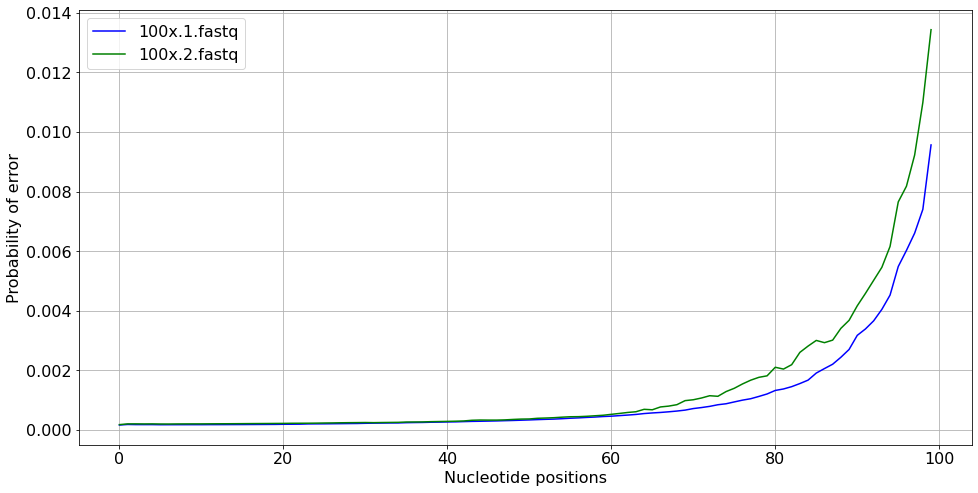

In [105]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.rcParams.update({'font.size': 16})

ax.plot(errors_list1[0], errors_list1[1], color = 'blue', label = '100x.1.fastq')
ax.plot(errors_list2[0], errors_list2[1], color = 'green', label = '100x.2.fastq')

plt.xlabel('Nucleotide positions')
plt.ylabel('Probability of error')
leg = ax.legend()
plt.grid()

Как видно из графиков, чем больше позиция нуклеотида в риде, тем выше вероятность ошибки.

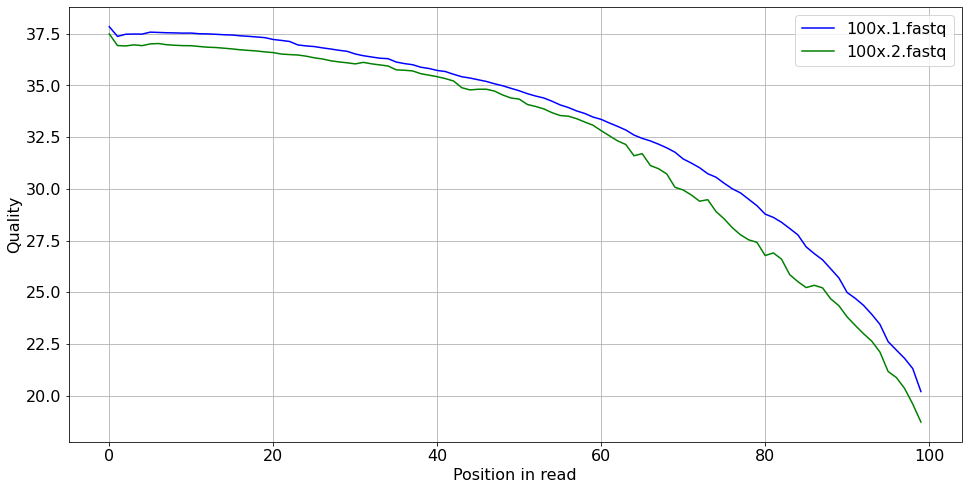

In [91]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.rcParams.update({'font.size': 16})

ax.plot(errors_list1[0], -10 * np.log10(np.array(errors_list1[1])), color = 'blue', label = '100x.1.fastq')
ax.plot(errors_list2[0], -10 * np.log10(np.array(errors_list2[1])), color = 'green', label = '100x.2.fastq')

plt.xlabel('Position in read')
plt.ylabel('Quality')
leg = ax.legend()
plt.grid()

## 3. Проверка результатов

Результаты работы программы FastQC для двух файлов (для первого и второго, соответственно).

![1](1.png)

![2](2.png)

![1_](1_.png)

![2_](2_.png)

Как видно, результаты работы функций ```GC(file)``` и ```errors(file)``` совпадают.

## Улучшение результатов

Попробуем не учитывать риды с плохим качеством.

In [5]:
def GC_better(file):
    GC_list = [i for i in range(101)]
    
    for index, record in enumerate(SeqIO.parse(file, 'fastq')):
        sequence = record.seq
        num_nucl = Counter(sequence)
        GC_freq = round((num_nucl['G'] + num_nucl['C']) * 100 / len(sequence), 2)
        if (sum(record.letter_annotations['phred_quality'])/len(record.letter_annotations['phred_quality'])) > 28:
            GC_list[int(GC_freq)] += 1
        
    return GC_list

In [6]:
GC_list1_better = GC_better('100x.1.fastq')
GC_list2_better = GC_better('100x.2.fastq')

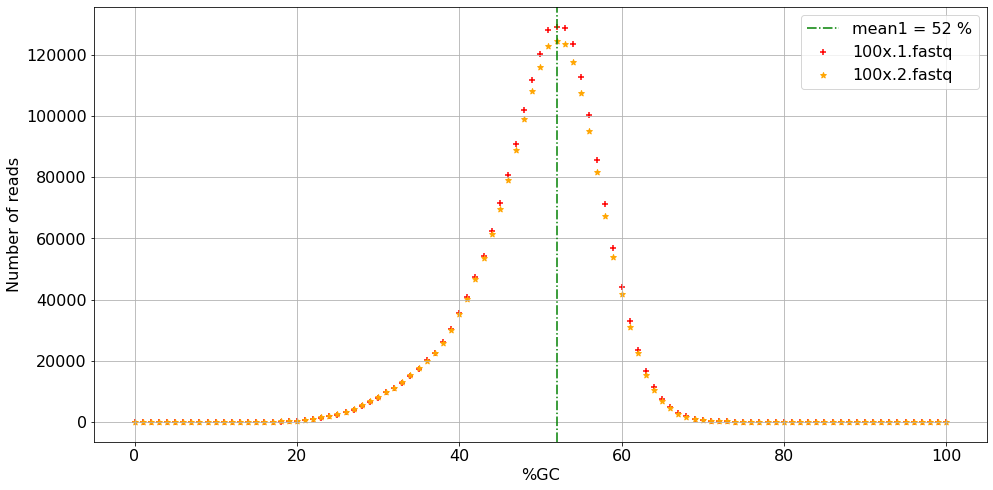

In [7]:
x, y, z = np.array([i for i in range(101)]), np.array(GC_list1_better), np.array(GC_list2_better)

fig, ax = plt.subplots(figsize=(16, 8))
plt.rcParams.update({'font.size': 16})

ax.scatter(x, y, marker = '+', color = 'red', label = '100x.1.fastq')
ax.scatter(x, z, marker = '*', color = 'orange', label = '100x.2.fastq')
ax.axvline(x = x[np.argmax(y)], color='green', linestyle='-.', label = f'mean1 = {x[np.argmax(y)]} %')

plt.xlabel('%GC')
plt.ylabel('Number of reads')
leg = ax.legend()
plt.grid()

Как видно, график теперь больше похож на Teoretical Distribution из FastQC.